# Overview

This notebook describes the different stages to build up different machine learning models trained over the dataset called **FakeNewsNet** by using  both **Word2Vec** and **Glove** Embeddings, for the automatic fake news detection

List of Machine Learning algorithms included 
- SVM
- Random Forest
- XgBoost
- KNN
- Naive Bayes
- Logistic Regression



## 1. Loading Python libraries

In [1]:
import numpy as np
import pandas as pd
import warnings
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import json
import tldextract   # Accurately separates a URL's subdomain, domain, and public suffix
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import re
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
import nltk 
import spacy
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from wordcloud import WordCloud, ImageColorGenerator,STOPWORDS
import gensim
from gensim.parsing.preprocessing import STOPWORDS as gensim_stopwords
import copy
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords,wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer,LancasterStemmer
from sklearn.metrics import f1_score
from pprint import pprint
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_colwidth', 1000)

[nltk_data] Downloading package stopwords to
[nltk_data]     /gpfs/home/psc21zcu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /gpfs/home/psc21zcu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /gpfs/home/psc21zcu/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /gpfs/home/psc21zcu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


***
## 2. Dataset Cleaning and Preprocessing

From the downloaded Fakenewsnet dataset, assign four variables with corresponding paths urls for the two class-labelled variables that should be in the common **input_dataset** folder as created for the whole experiment.

In [3]:
foldr_pol_real = 'input_dataset//fakenewsnet//politifact//real//'
foldr_pol_fake = 'input_dataset//fakenewsnet//politifact//fake//'
foldr_gos_real = 'input_dataset//fakenewsnet//gossipcop//real//'
foldr_gos_fake = 'input_dataset//fakenewsnet//gossipcop//fake//'

*** 

### Function to extract or convert  attributes from JSON  News Content format to  dataframe

This script is using to extract multiple attributes of the news content from the JSON file  and filtered the domain names from the url attribute  and created a new dataframe.


In [4]:
def json_to_newscontent(datapath):
    dictlist = []
    cols = ['url','text','title','authors','num_images','domain']
    folders = glob.glob(datapath+'/*')
    for index, subdir in enumerate(folders):
        path_file = glob.glob(subdir+'/*')
        #check whether file path is valid or not
        if len(path_file) == 1:
            file = open(path_file[0]).read()
            jsondata = json.loads(file)
            thedict = {'url':jsondata['url'],'title':jsondata['title'],'text':jsondata['text'],
                   'num_images':len(jsondata['images']),'authors':str(jsondata['authors'])}
            extrt_url = tldextract.extract(jsondata['url'])
            thedict['domain'] = extrt_url.domain
            dictlist.append(thedict)
    df=pd.DataFrame(dictlist,columns=cols)
    return df

##### Converting seperate dataframes for Politfact fake and real and Gossip fake and real

In [5]:
import time

# get the start time
st = time.time()

df_pol_real = json_to_newscontent(foldr_pol_real)
df_pol_fake = json_to_newscontent(foldr_pol_fake)
df_gos_real = json_to_newscontent(foldr_gos_real)
df_gos_fake = json_to_newscontent(foldr_gos_fake)

# get the end time
et = time.time()

# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

Execution time: 374.3071653842926 seconds


##### Removing rows having  missing value in the column named 'TEXT'

In [6]:
## Cleaned dataset
df_pol_real = df_pol_real.loc[df_pol_real["text"] != '' ]
df_pol_fake = df_pol_fake.loc[df_pol_fake["text"] != '' ]
df_gos_real = df_gos_real.loc[df_gos_real["text"] != '' ]
df_gos_fake = df_gos_fake.loc[df_gos_fake["text"] != '' ]

df_pol_real.reset_index(drop=True,inplace=True)
df_pol_fake.reset_index(drop=True,inplace=True)
df_gos_real.reset_index(drop=True,inplace=True)
df_gos_fake.reset_index(drop=True,inplace=True)

Created one new column named **Category** to identify whether a news article belongs to Politics or Gossip related

In [7]:
df_pol_real['Category'] = 'Politics' 
df_pol_fake['Category'] = 'Politics'
df_gos_real['Category'] = 'Gossips'
df_gos_fake['Category'] = 'Gossips'

Added response variable 'class' based on True=1 or Fake=0, in each dataframe

In [8]:
df_pol_real['class'] = 0 #True
df_pol_fake['class'] = 1 #Fake
df_gos_real['class'] = 0
df_gos_fake['class'] = 1

Merging all the four dataframes into a single dataframe for the further steps

In [12]:
df_list = [df_pol_real,df_pol_fake,df_gos_real,df_gos_fake]

In [13]:
#combine df's into one
df = pd.concat(df_list).reset_index(drop=True)
total_rows = df.shape[0]

#####  Next step is to create a new column named  'fulltext'  with the combination of 'title' and 'text' columns

In [15]:
df['fulltext']=df['title']+'.'+df['text']
df=df.dropna()
df.shape

(20275, 9)

#### Saving Fulldataset to csv format in  a location

In [16]:
df.to_csv('Updated//fakenesnet_full_dataset.csv', index=False)

Create a new dataframe by considering two columns 'fulltext' and 'class'

In [4]:
filterd_df=df[['fulltext','class']]

#### Preprocess the fulltext column using the built in cleaner option in gensim library

In [ ]:
filterd_df['cleantext'] = filterd_df['fulltext'].apply(lambda x: gensim.utils.simple_preprocess(x))

***

## 3. Model Training and Evaluation

### Splitting dataset into train and test

In [6]:
X=filterd_df['cleantext']
y=filterd_df['class']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y, random_state=0)

####  User defined helper functions to find out the accuracy score metrics and creation of model comparison table


- The function named **metrics** is using to calculate the score of the different metrics such as Accuracy, Precision, Recall, F1Score and ROC AUC score for the given classifier with test data


- The function named **model_comparison_table** is using to create dataframe to list down all the classifiers with the metrics scores for the comparison purpose

In [8]:
import timeit
from timeit import default_timer as timer
from datetime import timedelta
 


def metrics(X_test,y_test,clf):
    predictions=clf.predict(X_test)
    #predictions=(clf.predict_proba(X_test)[:,1] >= 0.3).astype(bool)
    print("confusion_matrix :")
    print(confusion_matrix(y_test,predictions))
    print("Accuracy Score :")
    print(accuracy_score(y_test, predictions))
    print("Classification Report :")
    print(classification_report(y_test, predictions))
    print("F1 score :")
    print(f1_score(y_test, predictions))
    print("ROC AUC Score")
    y_pred_proba = clf.predict_proba(X_test)
    print(roc_auc_score(y_test, y_pred_proba[:,1]) )
    print("------------------------------")

    
def model_comparison_table(X_test,y_test,classifier_list):
    dict_clf={}
    for clf_name,clf in classifier_list:
        predictions=clf.predict(X_test)
        y_pred_proba = clf.predict_proba(X_test)
        accuracy=accuracy_score(y_test, predictions)
        precision=precision_score(y_test,predictions,average='macro').round(2)
        recall=recall_score(y_test,predictions)
        f1score=f1_score(y_test,predictions).round(2)
        ROC_AUC=roc_auc_score(y_test, y_pred_proba[:,1])
        dict_clf[clf_name]=[accuracy,precision,recall,f1score,ROC_AUC]
    df_models_scores = pd.DataFrame(dict_clf, index=['Accuracy', 'Precision', 'Recall', 'F1 Score','roc_auc_score'])
    return df_models_scores

#### User defined helper functions to create the confusion matrix and normalised confusion matrix 

The below scripts is using to create the confusion matrix and normalised confusion matrix based on the predictions and actual truth lables

In [9]:
# Helper function to plot confusion matrix and normalised confusion matrix plot
def confusn_mtrx_plot(cm,path):
    from sklearn.metrics import confusion_matrix
    # Y_pred_evc = evc_mdl.predict(test_X)
    #cm = confusion_matrix(ytrue, y_pred)

    fig = plt.figure(figsize=(6, 5), dpi=60)
    ax = plt.subplot()
    sns.set(font_scale=1.4) # Adjust to fit
    sns.heatmap(cm, annot=True, ax=ax, cmap="GnBu", fmt="g");  
    #sns.heatmap(cm/np.sum(cm), annot=True, ax=ax[1], cmap="GnBu", fmt="g");  

    # Labels, title and ticks
    label_font = {'size':'18'}  # Adjust to fit
    ax.set_xlabel('Predicted', fontdict=label_font);
    ax.set_ylabel('Actuals', fontdict=label_font);

    title_font = {'size':'20'}  # Adjust to fit
    ax.set_title('Confusion Matrix', fontdict=title_font);

    ax.tick_params(axis='both', which='major', labelsize=15)  # Adjust to fit
    ax.xaxis.set_ticklabels(['Real', 'Fake']);
    ax.yaxis.set_ticklabels(['Real', 'Fake']);
    #fig.show()
    fig.savefig(path)
    
def norm_confusn_mtrx_plot(cm,path):
    fig = plt.figure(figsize=(6, 5), dpi=60)
    ax = plt.subplot()
    sns.set(font_scale=1.4) # Adjust to fit
    sns.heatmap(cm/np.sum(cm), annot=True, ax=ax, cmap="GnBu",fmt='.2%');  

    # Labels, title and ticks
    label_font = {'size':'18'}  # Adjust to fit
    ax.set_xlabel('Predicted', fontdict=label_font);
    ax.set_ylabel('Actuals', fontdict=label_font);

    title_font = {'size':'18'}  # Adjust to fit
    ax.set_title('Normalised Confusion Matrix', fontdict=title_font);

    ax.tick_params(axis='both', which='major', labelsize=15)  # Adjust to fit
    ax.xaxis.set_ticklabels(['Real', 'Fake']);
    ax.yaxis.set_ticklabels(['Real', 'Fake']);
    fig.savefig(path)

### Feature Extractions using pretrained word2vec model

#### Load Gensim Downloader library

In [10]:
import gensim.downloader

##### Download the  pretrained model

In [ ]:
!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

#### After downloading it, you can load it as follows

In [12]:
path_to_model = 'Embeddings//GoogleNews-vectors-negative300.bin'

In [13]:
from gensim.models.keyedvectors import KeyedVectors
%time w2v_model = KeyedVectors.load_word2vec_format(path_to_model, binary=True)
print('done loading Word2Vec')

CPU times: user 19.5 s, sys: 1.64 s, total: 21.1 s
Wall time: 21.1 s
done loading Word2Vec


#### Then inspect the model by getting the list of index of key values from the pretrained model

In [14]:
#Inspect the model
word2vec_vocab = list(w2v_model.index_to_key)

In [15]:
word2vec_vocab_lower = [item.lower() for item in word2vec_vocab]

#### User defined Function to create a feature vector by averaging all embeddings for the given sentence using the below user defined function

In [17]:
# Creating a feature vector by averaging all embeddings for all sentences
def embedding_feats(list_of_lists):
    DIMENSION = 300
    zero_vector = np.zeros(DIMENSION)
    feats = []
    for tokens in list_of_lists:
        feat_for_this =  np.zeros(DIMENSION)
        count_for_this = 0 + 1e-5 # to avoid divide-by-zero 
        for token in tokens:
            if token in w2v_model:
                feat_for_this += w2v_model[token]
                count_for_this +=1
        if(count_for_this!=0):
            feats.append(feat_for_this/count_for_this) 
        else:
            feats.append(zero_vector)
    return feats




16220


#### Then fit the training data and transform both training and test data

In [18]:
train_vectors = embedding_feats(X_train)
test_vectors = embedding_feats(X_test)

4055


## Model Training 

### RandomForest

**Initialise the  model and  fit using train data**

In [19]:
rf = RandomForestClassifier(random_state=0)
rf_model = rf.fit(train_vectors, y_train.values.ravel())

**Predict using test data and measure the accuracy metrics**

In [20]:
# Use the trained model to make predictions on the test data
y_pred = rf_model.predict(test_vectors)
print("Accuracy score : {}".format(accuracy_score(y_test, y_pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, y_pred)))
print("Classification Report")
print(classification_report(y_test, y_pred))

precision = precision_score(y_test, y_pred)
print("Precision : {}".format(precision))
recall = recall_score(y_test, y_pred)
print("Recall : {}".format(recall))

Accuracy score : 0.836498150431566
Confusion matrix : 
 [[2983   65]
 [ 598  409]]
Classification Report
              precision    recall  f1-score   support

           0       0.83      0.98      0.90      3048
           1       0.86      0.41      0.55      1007

    accuracy                           0.84      4055
   macro avg       0.85      0.69      0.73      4055
weighted avg       0.84      0.84      0.81      4055

Precision : 0.8628691983122363
Recall : 0.40615690168818275


### Hyperparameter Tuning for Random Forest

Define the list of parameters which needed to do hyperparameter tuning


In [ ]:
# Number of trees in random forest
n_estimators =[int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth =[int(x) for x in np.linspace(10, 110, num = 11)]
#Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {
    'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap
              }
pprint(random_grid)



**Apply RandomizedSearchCV library for hyperparameter tuning  and fit the train data**

In [ ]:
rf_clf1=RandomForestClassifier(random_state=0)

In [ ]:
rf_random = RandomizedSearchCV(estimator=rf_clf1, param_distributions=random_grid,
                              n_iter = 100, 
                              cv = 3, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)


# Fit the random search model
rf_random.fit(train_vectors, y_train.values.ravel())

In [32]:
rf_random.best_params_

{'n_estimators': 400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 70,
 'bootstrap': False}

#### Train Random Forest using with Best Params  and save it to a path

In [22]:
rf_clf_tuned=RandomForestClassifier(random_state=0,n_estimators=400,max_features='sqrt',max_depth=70,min_samples_split=2,min_samples_leaf=1,bootstrap=False)

rf_clf_tuned.fit(train_vectors, y_train.values.ravel())

import pickle
# save the model to disk
filename = 'outputs//fakenewsnet_ml_word2vec//fakenewsnet_ml_RF_w2v.sav'
pickle.dump(rf_clf_tuned, open(filename, 'wb'))
print('RandomForest - Completed')

RandomForest - Completed


**Load the saved model and predict using test data and measure the accuracy metrics**

In [23]:
#Loading the model
filename = 'outputs//fakenewsnet_ml_word2vec//fakenewsnet_ml_RF_w2v.sav'

rf_clf_tuned = pickle.load(open(filename, 'rb'))

pred = rf_clf_tuned.predict(test_vectors)
print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Classification Report")
print(classification_report(y_test, pred))
precision = precision_score(y_test, pred)
print("Precision : {}".format(precision))
recall = recall_score(y_test, pred)
print("Recall : {}".format(recall))
f1score = f1_score(y_test, pred)
print("F1 Score : {}".format(f1score))


Accuracy score : 0.8401972872996301
Confusion matrix : 
 [[2987   61]
 [ 587  420]]
Classification Report
              precision    recall  f1-score   support

           0       0.84      0.98      0.90      3048
           1       0.87      0.42      0.56      1007

    accuracy                           0.84      4055
   macro avg       0.85      0.70      0.73      4055
weighted avg       0.85      0.84      0.82      4055

Precision : 0.8731808731808732
Recall : 0.4170804369414101
F1 Score : 0.564516129032258


**Save the classification report to csv**

In [25]:
report=classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("outputs//fakenewsnet_ml_word2vec//model_FAKENEWSNET_RF_WORD2VEC_clasifctnrpt.csv")

**Plot confusion matrix using the user defined functions as mentioned above earlier**

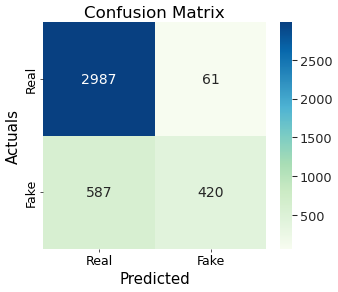

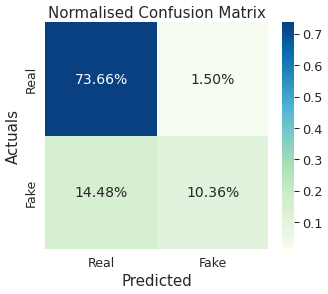

In [27]:
cm=confusion_matrix(y_test, pred)
path1="outputs//fakenewsnet_ml_word2vec//fakenewsnet_ml_RF_word2vec_cmtrx.png"
path2="outputs//fakenewsnet_ml_word2vec//fakenewsnet_ml_RF_word2vec_ncmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)

***

### Support Vector Machine

**Initialise SVM model and  fit the model and measure the accuracy metrics**

In [28]:
svm_clf=SVC(random_state=0)

In [29]:
svm_clf.fit(train_vectors,y_train)

pred = svm_clf.predict(test_vectors)
print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Classification Report")
print(classification_report(y_test, pred))

Accuracy score : 0.8438964241676942
Confusion matrix : 
 [[2986   62]
 [ 571  436]]
Classification Report
              precision    recall  f1-score   support

           0       0.84      0.98      0.90      3048
           1       0.88      0.43      0.58      1007

    accuracy                           0.84      4055
   macro avg       0.86      0.71      0.74      4055
weighted avg       0.85      0.84      0.82      4055



### Hyperparameter Tuning for SVM

Define the list of parameters which needed to do hyperparameter tuning

In [40]:
# Create the random grid
random_grid = {
    'C': [0.1, 1, 10, 100, 1000],
               'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
               'kernel':  ['rbf', 'poly', 'sigmoid'],
              }
pprint(random_grid)


{'C': [0.1, 1, 10, 100, 1000],
 'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
 'kernel': ['rbf', 'poly', 'sigmoid']}


**Initialise the model and fit using train data with hyperparameter tuning**

In [41]:

svm_clf1=SVC(random_state=0)

rf_random = RandomizedSearchCV(estimator=svm_clf1, param_distributions=random_grid,
                              n_iter = 50, 
                              cv = 5, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)


# Fit the random search model
rf_random.fit(train_vectors,y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5, estimator=SVC(random_state=0), n_iter=50, n_jobs=-1,
                   param_distributions={'C': [0.1, 1, 10, 100, 1000],
                                        'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                                        'kernel': ['rbf', 'poly', 'sigmoid']},
                   random_state=42, return_train_score=True, verbose=2)

[CV] END ......................C=0.1, gamma=0.1, kernel=poly; total time=  43.2s
[CV] END .......................C=10, gamma=0.1, kernel=poly; total time= 1.2min
[CV] END .......................C=1, gamma=0.01, kernel=poly; total time= 1.3min
[CV] END .....................C=10, gamma=0.001, kernel=poly; total time= 1.3min
[CV] END ...................C=100, gamma=0.0001, kernel=poly; total time= 1.3min
[CV] END ...............C=1000, gamma=0.0001, kernel=sigmoid; total time= 1.4min
[CV] END .................C=1000, gamma=0.01, kernel=sigmoid; total time= 1.4min
[CV] END .......................C=1000, gamma=1, kernel=poly; total time= 5.0min
[CV] END .....................C=10, gamma=0.001, kernel=poly; total time= 1.1min
[CV] END .....................C=100, gamma=1, kernel=sigmoid; total time= 1.3min
[CV] END ...............C=1000, gamma=0.0001, kernel=sigmoid; total time= 1.3min
[CV] END .................C=1000, gamma=0.01, kernel=sigmoid; total time= 1.5min
[CV] END ...................

[CV] END ......................C=1000, gamma=0.1, kernel=rbf; total time= 2.2min
[CV] END .................C=100, gamma=0.001, kernel=sigmoid; total time= 1.4min
[CV] END ..........................C=10, gamma=1, kernel=rbf; total time= 1.7min
[CV] END ..................C=0.1, gamma=0.01, kernel=sigmoid; total time= 1.1min
[CV] END ..................C=1000, gamma=0.0001, kernel=poly; total time= 1.4min
[CV] END ....................C=1000, gamma=0.001, kernel=rbf; total time= 1.6min
[CV] END .................C=100, gamma=0.001, kernel=sigmoid; total time= 1.4min
[CV] END ..........................C=10, gamma=1, kernel=rbf; total time= 1.6min
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time= 1.8min
[CV] END ....................C=1000, gamma=0.001, kernel=rbf; total time= 1.6min
[CV] END ...................C=0.1, gamma=0.1, kernel=sigmoid; total time= 1.4min
[CV] END .................C=10, gamma=0.0001, kernel=sigmoid; total time= 1.2min
[CV] END ..................C

[CV] END ......................C=1000, gamma=0.1, kernel=rbf; total time= 2.2min
[CV] END ........................C=10, gamma=0.1, kernel=rbf; total time= 1.7min
[CV] END .....................C=100, gamma=1, kernel=sigmoid; total time=  48.5s
[CV] END ......................C=1, gamma=0.001, kernel=poly; total time= 1.1min
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time= 1.9min
[CV] END ....................C=0.1, gamma=0.001, kernel=poly; total time=  47.1s
[CV] END .......................C=10, gamma=0.1, kernel=poly; total time= 1.3min
[CV] END .......................C=1, gamma=0.01, kernel=poly; total time= 1.2min
[CV] END .....................C=10, gamma=0.001, kernel=poly; total time= 1.2min
[CV] END ...................C=100, gamma=0.0001, kernel=poly; total time= 1.1min
[CV] END ......................C=1, gamma=0.001, kernel=poly; total time= 1.2min
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time= 2.0min
[CV] END ...................

In [42]:
rf_random.best_params_

{'kernel': 'rbf', 'gamma': 1, 'C': 10}

### Train SVM model  using Best Parameters after hyperparameter tuning

**Initialise the model and  fit it using train data and measure the accuracy metrics**

In [30]:
svm_clf_tuned=SVC(random_state=0,kernel='rbf',gamma=1,C=10,probability=True)

svm_clf_tuned.fit(train_vectors, y_train.values.ravel())

# save the model to disk
filename = 'outputs//fakenewsnet_ml_word2vec//fakenewsnet_ml_SVM_w2v.sav'
pickle.dump(svm_clf_tuned, open(filename, 'wb'))
print('SVM - Completed')

SVM - Completed


In [31]:
#Loading the model
filename = 'outputs//fakenewsnet_ml_word2vec//fakenewsnet_ml_SVM_w2v.sav'

svm_clf_tuned = pickle.load(open(filename, 'rb'))

pred = svm_clf_tuned.predict(test_vectors)
print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Classification Report")
print(classification_report(y_test, pred))
precision = precision_score(y_test, pred)
print("Precision : {}".format(precision))
recall = recall_score(y_test, pred)
print("Recall : {}".format(recall))
f1score = f1_score(y_test, pred)
print("F1 Score : {}".format(f1score))


Accuracy score : 0.8493218249075216
Confusion matrix : 
 [[2950   98]
 [ 513  494]]
Classification Report
              precision    recall  f1-score   support

           0       0.85      0.97      0.91      3048
           1       0.83      0.49      0.62      1007

    accuracy                           0.85      4055
   macro avg       0.84      0.73      0.76      4055
weighted avg       0.85      0.85      0.83      4055

Precision : 0.8344594594594594
Recall : 0.49056603773584906
F1 Score : 0.6178861788617885


**Save the classification report to csv**

In [32]:
report=classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("outputs//fakenewsnet_ml_word2vec//model_FAKENEWSNET_SVM_WORD2VEC_clasifctnrpt.csv")
df.head()

,precision,recall,f1-score,support
0,0.851863,0.967848,0.906159,3048.000000
1,0.834459,0.490566,0.617886,1007.000000
accuracy,0.849322,0.849322,0.849322,0.849322
macro avg,0.843161,0.729207,0.762022,4055.000000
weighted avg,0.847541,0.849322,0.834571,4055.000000


**Plot confusion matrix using the user defined functions as mentioned above earlier**

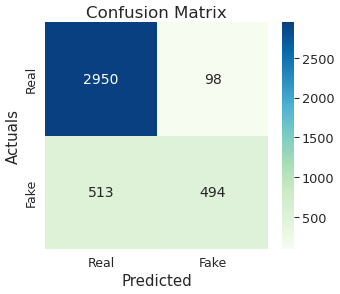

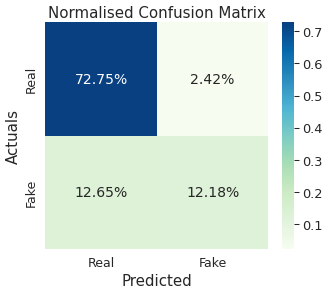

In [33]:
cm=confusion_matrix(y_test, pred)
path1="outputs//fakenewsnet_ml_word2vec//fakenewsnet_ml_SVM_word2vec_cmtrx.png"
path2="outputs//fakenewsnet_ml_word2vec//fakenewsnet_ml_SVM_word2vec_ncmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)

## KNN

**Initialise the model and  fit it using train data and measure the accuracy metrics**

In [34]:
#Create KNN Object.
knn_clf = KNeighborsClassifier()

In [35]:
knn_clf.fit(train_vectors,y_train)

pred = knn_clf.predict(test_vectors)
print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Classification Report")
print(classification_report(y_test, pred))

Accuracy score : 0.7916152897657214
Confusion matrix : 
 [[2724  324]
 [ 521  486]]
Classification Report
              precision    recall  f1-score   support

           0       0.84      0.89      0.87      3048
           1       0.60      0.48      0.53      1007

    accuracy                           0.79      4055
   macro avg       0.72      0.69      0.70      4055
weighted avg       0.78      0.79      0.78      4055



### Hyperparameter Tuning for KNN

Define the list of parameters which needed to do hyperparameter tuning

In [47]:
# Create the random grid
random_grid = {
    'leaf_size': list(range(1,50)),
               'n_neighbors': list(range(1,30)),
               'p':  [1,2],
              }
pprint(random_grid)

{'leaf_size': [1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
               47,
               48,
               49],
 'n_neighbors': [1,
                 2,
                 3,
                 

**Initialise the model and fit using train data with hyperparameter tuning**

In [48]:

knn_clf1=KNeighborsClassifier()

rf_random = RandomizedSearchCV(estimator=knn_clf1, param_distributions=random_grid,
                              n_iter = 100, 
                              cv = 3, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)


# Fit the random search model
rf_random.fit(train_vectors,y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=KNeighborsClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'leaf_size': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19, 20, 21,
                                                      22, 23, 24, 25, 26, 27,
                                                      28, 29, 30, ...],
                                        'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8,
                                                        9, 10, 11, 12, 13, 14,
                                                        15, 16, 17, 18, 19, 20,
                                                        21, 22, 23, 24, 25, 26,
                                                        27, 28, 29],
                                        'p': [1, 2]},
                   random_state=42, return_train_score=True, verbose=2

In [49]:
rf_random.best_params_

{'p': 1, 'n_neighbors': 28, 'leaf_size': 7}

### Train KNN model  using Best Parameters after hyperparameter tuning

**Initialise the model and  fit it using train data and measure the accuracy metrics**

In [36]:
knn_clf_tuned=KNeighborsClassifier(n_neighbors=28,leaf_size=7,p=1)
knn_clf_tuned.fit(train_vectors,y_train)

# save the model to disk
filename = 'outputs//fakenewsnet_ml_word2vec//fakenewsnet_ml_KNN_w2v.sav'
pickle.dump(knn_clf_tuned, open(filename, 'wb'))
print('KNN - Completed')

KNN - Completed


In [38]:
#Loading the model
filename = 'outputs//fakenewsnet_ml_word2vec//fakenewsnet_ml_KNN_w2v.sav'

knn_clf_tuned = pickle.load(open(filename, 'rb'))

pred = knn_clf_tuned.predict(test_vectors)
print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Classification Report")
print(classification_report(y_test, pred))
precision = precision_score(y_test, pred)
print("Precision : {}".format(precision))
recall = recall_score(y_test, pred)
print("Recall : {}".format(recall))
f1score = f1_score(y_test, pred)
print("F1 Score : {}".format(f1score))


Accuracy score : 0.821948212083847
Confusion matrix : 
 [[2936  112]
 [ 610  397]]
Classification Report
              precision    recall  f1-score   support

           0       0.83      0.96      0.89      3048
           1       0.78      0.39      0.52      1007

    accuracy                           0.82      4055
   macro avg       0.80      0.68      0.71      4055
weighted avg       0.82      0.82      0.80      4055

Precision : 0.7799607072691552
Recall : 0.394240317775571
F1 Score : 0.5237467018469657


**Save the classification report to csv**

In [39]:
report=classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("outputs//fakenewsnet_ml_word2vec//model_FAKENEWSNET_KNN_WORD2VEC_clasifctnrpt.csv")

df.head()

,precision,recall,f1-score,support
0,0.827975,0.963255,0.890507,3048.000000
1,0.779961,0.394240,0.523747,1007.000000
accuracy,0.821948,0.821948,0.821948,0.821948
macro avg,0.803968,0.678747,0.707127,4055.000000
weighted avg,0.816051,0.821948,0.799427,4055.000000


**Plot confusion matrix using the user defined functions as mentioned above earlier**

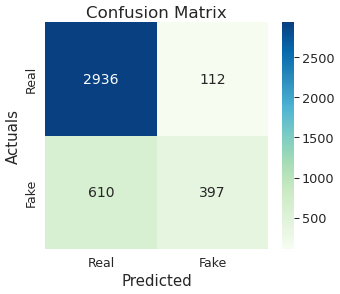

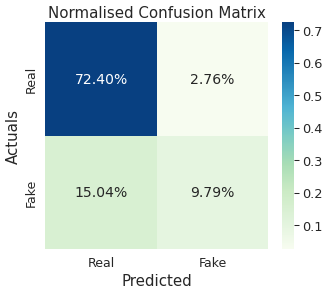

In [40]:
cm=confusion_matrix(y_test, pred)
path1="outputs//fakenewsnet_ml_word2vec//fakenewsnet_ml_KNN_word2vec_cmtrx.png"
path2="outputs//fakenewsnet_ml_word2vec//fakenewsnet_ml_KNN_word2vec_ncmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)

### Xgboost

**Initialise the model and  fit it using train data and measure the accuracy metrics**

In [41]:
#Create KNN Object.
xg_clf=XGBClassifier(random_state=0)

xg_clf.fit(train_vectors,y_train)

pred = xg_clf.predict(test_vectors)
print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Classification Report")
print(classification_report(y_test, pred))


Accuracy score : 0.847842170160296
Confusion matrix : 
 [[2911  137]
 [ 480  527]]
Classification Report
              precision    recall  f1-score   support

           0       0.86      0.96      0.90      3048
           1       0.79      0.52      0.63      1007

    accuracy                           0.85      4055
   macro avg       0.83      0.74      0.77      4055
weighted avg       0.84      0.85      0.84      4055



### Hyperparameter Tuning for KNN

Define the list of parameters which needed to do hyperparameter tuning

In [52]:
# Create the random grid
random_grid = {
    'min_child_weight': range(1,6,2),
    'gamma': list(range(1,30)),
    'max_depth':  range(3,15,2),
    'alpha': [1e-5, 1e-2, 0.1,1,10,50, 100],
    'subsample':np.arange(0.5, 1.0, 0.1),
    'scale_pos_weight':range(1,5,1),
    'colsample_bytree':np.arange(0.5, 1.0, 0.1),
    'n_estimators':[100, 250, 500],
    'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.4],
    'colsample_bylevel': np.arange(0.5, 1.0, 0.1),
    }
pprint(random_grid)

{'alpha': [1e-05, 0.01, 0.1, 1, 10, 50, 100],
 'colsample_bylevel': array([0.5, 0.6, 0.7, 0.8, 0.9]),
 'colsample_bytree': array([0.5, 0.6, 0.7, 0.8, 0.9]),
 'gamma': [1,
           2,
           3,
           4,
           5,
           6,
           7,
           8,
           9,
           10,
           11,
           12,
           13,
           14,
           15,
           16,
           17,
           18,
           19,
           20,
           21,
           22,
           23,
           24,
           25,
           26,
           27,
           28,
           29],
 'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.4],
 'max_depth': range(3, 15, 2),
 'min_child_weight': range(1, 6, 2),
 'n_estimators': [100, 250, 500],
 'scale_pos_weight': range(1, 5),
 'subsample': array([0.5, 0.6, 0.7, 0.8, 0.9])}


**Initialise the model and apply hyperparameter tuning**

In [53]:

xg_clf1=XGBClassifier(random_state=0)


rf_random = RandomizedSearchCV(estimator=xg_clf1, param_distributions=random_grid,
                              n_iter = 100, 
                              cv = 3, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)


# Fit the random search model
rf_random.fit(train_vectors,y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,...
                                        'colsample_bytree': array([0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'gam

In [55]:
rf_random.best_params_

{'subsample': 0.8999999999999999,
 'scale_pos_weight': 4,
 'n_estimators': 500,
 'min_child_weight': 3,
 'max_depth': 11,
 'learning_rate': 0.01,
 'gamma': 3,
 'colsample_bytree': 0.5,
 'colsample_bylevel': 0.8999999999999999,
 'alpha': 0.1}

### Train XgBoost model  using Best Parameters after hyperparameter tuning

**Initialise the model and  fit it using train data and measure the accuracy metrics**

In [42]:
xg_clf_tuned=XGBClassifier(subsample=0.89,scale_pos_weight=4,n_estimators=500,min_child_weight=3,max_depth=11,learning_rate=0.01,
                     gamma=3,colsample_bytree=0.5,colsample_bylevel=0.89,alpha=0.1)
xg_clf_tuned.fit(train_vectors,y_train)

# save the model to disk
filename = 'outputs//fakenewsnet_ml_word2vec//fakenewsnet_ml_XG_w2v.sav'
pickle.dump(xg_clf_tuned, open(filename, 'wb'))
print('XGBoost - Completed')

XGBoost - Completed


In [43]:
#Loading the model
filename = 'outputs//fakenewsnet_ml_word2vec//fakenewsnet_ml_XG_w2v.sav'

xg_clf_tuned = pickle.load(open(filename, 'rb'))

pred = xg_clf_tuned.predict(test_vectors)
print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Classification Report")
print(classification_report(y_test, pred))
precision = precision_score(y_test, pred)
print("Precision : {}".format(precision))
recall = recall_score(y_test, pred)
print("Recall : {}".format(recall))
f1score = f1_score(y_test, pred)
print("F1 Score : {}".format(f1score))


Accuracy score : 0.8463625154130703
Confusion matrix : 
 [[2833  215]
 [ 408  599]]
Classification Report
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      3048
           1       0.74      0.59      0.66      1007

    accuracy                           0.85      4055
   macro avg       0.80      0.76      0.78      4055
weighted avg       0.84      0.85      0.84      4055

Precision : 0.7358722358722358
Recall : 0.5948361469712016
F1 Score : 0.657880285557386


**Save the classification report to csv**

In [44]:
report=classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("outputs//fakenewsnet_ml_word2vec//model_FAKENEWSNET_XG_WORD2VEC_clasifctnrpt.csv")

df.head()

,precision,recall,f1-score,support
0,0.874113,0.929462,0.900938,3048.000000
1,0.735872,0.594836,0.657880,1007.000000
accuracy,0.846363,0.846363,0.846363,0.846363
macro avg,0.804993,0.762149,0.779409,4055.000000
weighted avg,0.839783,0.846363,0.840578,4055.000000


**Plot confusion matrix using the user defined functions as mentioned above earlier**

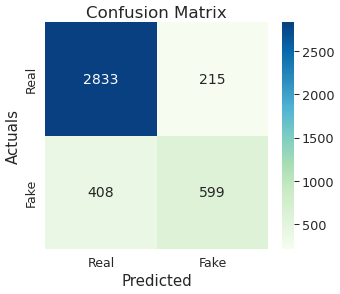

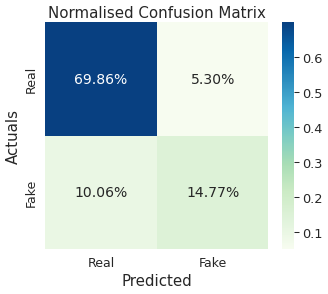

In [45]:
cm=confusion_matrix(y_test, pred)
path1="outputs//fakenewsnet_ml_word2vec//fakenewsnet_ml_XG_word2vec_cmtrx.png"
path2="outputs//fakenewsnet_ml_word2vec//fakenewsnet_ml_XG_word2vec_ncmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)

### Naiva Bayes

**Initialise the model and measure the accuracy metrics**

In [46]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import GaussianNB
nb_clf=GaussianNB()
#p = Pipeline([('Normalizing',MinMaxScaler()),('MultinomialNB',MultinomialNB())])
nb_clf.fit(train_vectors,y_train) 

pred = nb_clf.predict(test_vectors)
print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Classification Report")
print(classification_report(y_test, pred))

Accuracy score : 0.6244143033292232
Confusion matrix : 
 [[1756 1292]
 [ 231  776]]
Classification Report
              precision    recall  f1-score   support

           0       0.88      0.58      0.70      3048
           1       0.38      0.77      0.50      1007

    accuracy                           0.62      4055
   macro avg       0.63      0.67      0.60      4055
weighted avg       0.76      0.62      0.65      4055



### Hyperparameter Tuning for Naive Bayes

Define the list of parameters which needed to do hyperparameter tuning

In [72]:
# Create the random grid
random_grid = {
    'var_smoothing': [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
#    # 'class_prior':[True,False],
#     'fit_prior':[True,False]
              }
pprint(random_grid)

{'var_smoothing': [1e-05, 0.0001, 0.001, 0.1, 1, 10, 100, 1000]}


**Initialise the model and apply hyperparameter tuning**

In [73]:

nb_clf1=GaussianNB()


rf_random = RandomizedSearchCV(estimator=nb_clf1, param_distributions=random_grid,
                              n_iter = 100, 
                              cv = 3, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)


# Fit the random search model
rf_random.fit(train_vectors,y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


RandomizedSearchCV(cv=3, estimator=GaussianNB(), n_iter=100, n_jobs=-1,
                   param_distributions={'var_smoothing': [1e-05, 0.0001, 0.001,
                                                          0.1, 1, 10, 100,
                                                          1000]},
                   random_state=42, return_train_score=True, verbose=2)

In [71]:
nb_clf.get_params()

{'priors': None, 'var_smoothing': 1e-09}

In [74]:
rf_random.best_params_

{'var_smoothing': 10}

### Train Naive Bayes model  using Best Parameters after hyperparameter tuning

**Initialise the model and  fit it using train data and measure the accuracy metrics**

In [47]:
nb_clf_tuned=GaussianNB(var_smoothing=10)

nb_clf_tuned.fit(train_vectors,y_train)

# save the model to disk
filename = 'outputs//fakenewsnet_ml_word2vec//fakenewsnet_ml_NB_w2v.sav'
pickle.dump(nb_clf_tuned, open(filename, 'wb'))
print('Naive Bayes - Completed')

Naive Bayes - Completed


In [60]:
#Loading the model
filename = 'outputs//fakenewsnet_ml_word2vec//fakenewsnet_ml_NB_w2v.sav'

nb_clf_tuned = pickle.load(open(filename, 'rb'))

pred = nb_clf_tuned.predict(test_vectors)

print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Classification Report")
print(classification_report(y_test, pred))
precision = precision_score(y_test, pred)
print("Precision : {}".format(precision))
recall = recall_score(y_test, pred)
print("Recall : {}".format(recall))
f1score = f1_score(y_test, pred)
print("F1 Score : {}".format(f1score))


Accuracy score : 0.7935881627620222
Confusion matrix : 
 [[2940  108]
 [ 729  278]]
Classification Report
              precision    recall  f1-score   support

           0       0.80      0.96      0.88      3048
           1       0.72      0.28      0.40      1007

    accuracy                           0.79      4055
   macro avg       0.76      0.62      0.64      4055
weighted avg       0.78      0.79      0.76      4055

Precision : 0.7202072538860104
Recall : 0.27606752730883816
F1 Score : 0.3991385498923188


**Save the classification report to csv**

In [61]:
report=classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("outputs//fakenewsnet_ml_word2vec//model_FAKENEWSNET_NB_WORD2VEC_clasifctnrpt.csv")
df.head()

,precision,recall,f1-score,support
0,0.801308,0.964567,0.875391,3048.000000
1,0.720207,0.276068,0.399139,1007.000000
accuracy,0.793588,0.793588,0.793588,0.793588
macro avg,0.760758,0.620317,0.637265,4055.000000
weighted avg,0.781168,0.793588,0.757121,4055.000000


**Plot confusion matrix using the user defined functions as mentioned above earlier**

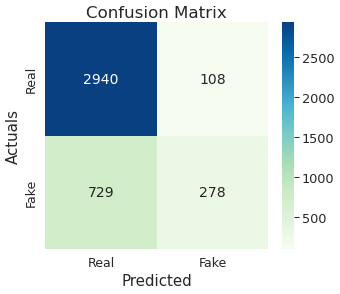

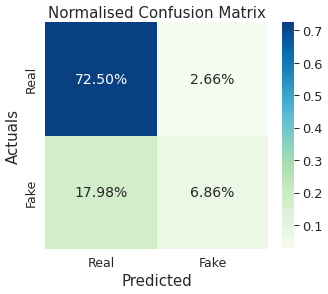

In [62]:
cm=confusion_matrix(y_test, pred)
path1="outputs//fakenewsnet_ml_word2vec//fakenewsnet_ml_NB_word2vec_cmtrx.png"
path2="outputs//fakenewsnet_ml_word2vec//fakenewsnet_ml_NB_word2vec_ncmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)

### Logistic Regression

**Initialise the model and  fit it using train data and measure the accuracy metrics**

In [63]:
from sklearn.linear_model import LogisticRegression

In [64]:
logticreg_clf=LogisticRegression()

logticreg_clf.fit(train_vectors,y_train)

pred = logticreg_clf.predict(test_vectors)
print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Classification Report")
print(classification_report(y_test, pred))

Accuracy score : 0.8271270036991368
Confusion matrix : 
 [[2970   78]
 [ 623  384]]
Classification Report
              precision    recall  f1-score   support

           0       0.83      0.97      0.89      3048
           1       0.83      0.38      0.52      1007

    accuracy                           0.83      4055
   macro avg       0.83      0.68      0.71      4055
weighted avg       0.83      0.83      0.80      4055



### Hyperparameter Tuning for Logistic Regression

Define the list of parameters which needed to do hyperparameter tuning

In [78]:
# Create the random grid
random_grid = {
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
     'C':[100, 10, 1.0, 0.1, 0.01],
    'penalty':['l1','l2','elasticnet']
              }
pprint(random_grid)

{'C': [100, 10, 1.0, 0.1, 0.01],
 'penalty': ['l1', 'l2', 'elasticnet'],
 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}


**Initialise the model and apply hyperparameter tuning**

In [79]:

logticreg_clf_tuned=LogisticRegression()


rf_random = RandomizedSearchCV(estimator=logticreg_clf_tuned, param_distributions=random_grid,
                              n_iter = 100, 
                              cv = 3, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)


# Fit the random search model
rf_random.fit(train_vectors,y_train)

Fitting 3 folds for each of 75 candidates, totalling 225 fits


RandomizedSearchCV(cv=3, estimator=LogisticRegression(), n_iter=100, n_jobs=-1,
                   param_distributions={'C': [100, 10, 1.0, 0.1, 0.01],
                                        'penalty': ['l1', 'l2', 'elasticnet'],
                                        'solver': ['newton-cg', 'lbfgs',
                                                   'liblinear', 'sag',
                                                   'saga']},
                   random_state=42, return_train_score=True, verbose=2)

In [80]:
rf_random.best_params_

{'solver': 'lbfgs', 'penalty': 'l2', 'C': 10}

### Train Logistic Regreesion model  using Best Parameters after hyperparameter tuning

**Initialise the model and  fit it using train data and measure the accuracy metrics**

In [65]:
logticreg_clf_tuned=LogisticRegression(solver='lbfgs',penalty='l2',C=10)

logticreg_clf_tuned.fit(train_vectors,y_train)

# save the model to disk
filename = 'outputs//fakenewsnet_ml_word2vec//fakenewsnet_ml_LR_w2v.sav'
pickle.dump(logticreg_clf_tuned, open(filename, 'wb'))
print('Logistic Regression - Completed')

Logistic Regression - Completed


In [66]:
#Loading the model
filename = 'outputs//fakenewsnet_ml_word2vec//fakenewsnet_ml_LR_w2v.sav'

logticreg_clf_tuned = pickle.load(open(filename, 'rb'))

pred = logticreg_clf_tuned.predict(test_vectors)

print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Classification Report")
print(classification_report(y_test, pred))
precision = precision_score(y_test, pred)
print("Precision : {}".format(precision))
recall = recall_score(y_test, pred)
print("Recall : {}".format(recall))
f1score = f1_score(y_test, pred)
print("F1 Score : {}".format(f1score))


Accuracy score : 0.8387176325524044
Confusion matrix : 
 [[2924  124]
 [ 530  477]]
Classification Report
              precision    recall  f1-score   support

           0       0.85      0.96      0.90      3048
           1       0.79      0.47      0.59      1007

    accuracy                           0.84      4055
   macro avg       0.82      0.72      0.75      4055
weighted avg       0.83      0.84      0.82      4055

Precision : 0.7936772046589018
Recall : 0.47368421052631576
F1 Score : 0.5932835820895522


**Save the classification report to csv**

In [67]:
report=classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("outputs//fakenewsnet_ml_word2vec//model_FAKENEWSNET_LR_WORD2VEC_clasifctnrpt.csv")
df.head()

,precision,recall,f1-score,support
0,0.846555,0.959318,0.899416,3048.000000
1,0.793677,0.473684,0.593284,1007.000000
accuracy,0.838718,0.838718,0.838718,0.838718
macro avg,0.820116,0.716501,0.746350,4055.000000
weighted avg,0.833423,0.838718,0.823392,4055.000000


**Plot confusion matrix using the user defined functions as mentioned above earlier**

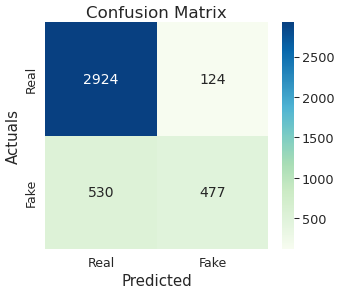

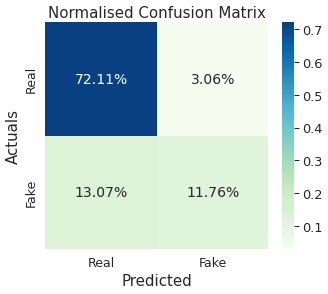

In [68]:
cm=confusion_matrix(y_test, pred)
path1="outputs//fakenewsnet_ml_word2vec//fakenewsnet_ml_LR_word2vec_cmtrx.png"
path2="outputs//fakenewsnet_ml_word2vec//fakenewsnet_ml_LR_word2vec_ncmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)

### Consolidating all classifiers for  accuracy scores

In [69]:
classifiers = [('Logistic Regression',logticreg_clf_tuned),('Naive Bayes',nb_clf_tuned),('Xgboost',xg_clf_tuned),
              ('KNN',knn_clf_tuned),('Random Forest',rf_clf_tuned),("SVM",svm_clf_tuned)]

In [71]:
df_model_scores=model_comparison_table(test_vectors,y_test,classifiers)
df_model_scores.head(20).T.sort_values(by='Accuracy', ascending=False)
df_model_scores.to_csv('outputs//fakenewsnet_ml_word2vec//comparison_scores.csv')

In [ ]:
df_model_scores.head()

### ROC AUC Curve plot using all the algorithms

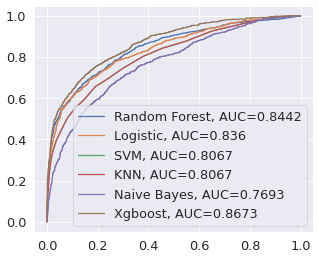

In [73]:
#set up plotting area
fig = plt.figure(figsize=(6, 5), dpi=60)
ax = plt.subplot()

#fit RF model and plot ROC curve
y_pred = rf_clf_tuned.predict_proba(test_vectors)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = round(roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Random Forest, AUC="+str(auc))

#fit Logistic model and plot ROC curve
y_pred = logticreg_clf_tuned.predict_proba(test_vectors)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = round(roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Logistic, AUC="+str(auc))


#fit SVM model and plot ROC curve
y_pred = svm_clf_tuned.predict_proba(test_vectors)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = round(roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="SVM, AUC="+str(auc))


#fit KNN model and plot ROC curve
y_pred = knn_clf_tuned.predict_proba(test_vectors)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = round(roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="KNN, AUC="+str(auc))

#fit Naive Bayes model and plot ROC curve
y_pred = nb_clf_tuned.predict_proba(test_vectors)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = round(roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Naive Bayes, AUC="+str(auc))

#fit Xgboost model and plot ROC curve
y_pred = xg_clf_tuned.predict_proba(test_vectors)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = round(roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Xgboost, AUC="+str(auc))

#add legend
plt.legend()
fig.savefig("outputs//fakenewsnet_ml_word2vec//ROC_AUC.png")

## Feature Extraction using Pretrained Glove

##### Download the pretrained zip file

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

#### Load the downloaded the 300 dimension Glove pretrained model "glove.6B.300d.txt" in a path and convert to word2vec format",

In [74]:
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

In [75]:
# Load 300 dimension Glove pretrained model "glove.6B.300d.txt" and convert to word2vec format",
path_to_model = '//gpfs//home//psc21zcu//FakeNews_Detection/Dissertation_Work//Embeddings//glove.6B.300d.txt'
output_file = '//gpfs//home//psc21zcu//FakeNews_Detection/Dissertation_Work//Embeddings///gensim_glove.6B.300d.txt'
glove2word2vec(path_to_model, output_file)

(400000, 300)

#### Then load the converted glove model 

In [77]:
%time glove_model = KeyedVectors.load_word2vec_format(output_file, binary=False)
print('done loading Glove Pretrained Embedding')

CPU times: user 44.4 s, sys: 582 ms, total: 45 s
Wall time: 45.1 s
done loading Glove Pretrained Embedding


### Function to create a feature vector by averaging all embeddings for the given sentence 

In [78]:
# Creating a feature vector by averaging all embeddings for all sentences
def glove_embedding_feats(list_of_lists):
    DIMENSION = 300
    zero_vector = np.zeros(DIMENSION)
    feats = []
    for tokens in list_of_lists:
        feat_for_this =  np.zeros(DIMENSION)
        count_for_this = 0 + 1e-5 # to avoid divide-by-zero 
        for token in tokens:
            if token in glove_model:
                feat_for_this += glove_model[token]
                count_for_this +=1
        if(count_for_this!=0):
            feats.append(feat_for_this/count_for_this) 
        else:
            feats.append(zero_vector)
    return feats


16220


#### Then fit the training data and transform both training and test data

In [79]:
glove_train_vectors = glove_embedding_feats(X_train)
glove_test_vectors = glove_embedding_feats(X_test)

4055


*** 
## Model Training 

### RandomForest

**Initialise the model and  fit it using train data and measure the accuracy metrics**

In [80]:
rf = RandomForestClassifier(random_state=0)
rf_model = rf.fit(glove_train_vectors, y_train.values.ravel())

In [81]:
# Use the trained model to make predictions on the test data
y_pred = rf_model.predict(glove_test_vectors)
print("Accuracy score : {}".format(accuracy_score(y_test, y_pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, y_pred)))
print("Classification Report")
print(classification_report(y_test, y_pred))

precision = precision_score(y_test, y_pred)
print("Precision : {}".format(precision))
recall = recall_score(y_test, y_pred)
print("Recall : {}".format(recall))

Accuracy score : 0.8305795314426634
Confusion matrix : 
 [[3001   47]
 [ 640  367]]
Classification Report
              precision    recall  f1-score   support

           0       0.82      0.98      0.90      3048
           1       0.89      0.36      0.52      1007

    accuracy                           0.83      4055
   macro avg       0.86      0.67      0.71      4055
weighted avg       0.84      0.83      0.80      4055

Precision : 0.8864734299516909
Recall : 0.3644488579940417


### Hyperparameter Tuning 

Define the list of parameters which needed to do hyperparameter tuning

In [103]:
# Number of trees in random forest
n_estimators =[int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth =[int(x) for x in np.linspace(10, 110, num = 11)]
#Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {
    'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap
              }
pprint(random_grid)



{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}


**Initialise the model and fit using train data with hyperparameter tuning**

In [104]:
rf_clf1=RandomForestClassifier(random_state=0)

In [105]:
rf_random = RandomizedSearchCV(estimator=rf_clf1, param_distributions=random_grid,
                              n_iter = 100, 
                              cv = 3, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)


# Fit the random search model
rf_random.fit(glove_train_vectors, y_train.values.ravel())

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time= 1.4min
[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time= 1.4min
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  29.5s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  27.2s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  29.7s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  14.5s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1

[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time= 2.0min
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=800; total time= 3.8min
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1000; total time= 4.9min
[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time= 2.3min
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  57.9s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=700; total time= 3.2min
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  12.2s
[CV] END bootstrap=True, max_depth=60, m

[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time= 1.4min
[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1000; total time= 3.1min
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=900; total time= 4.2min
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time= 2.1min
[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=900; total time= 2.3min
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time= 1.4min
[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=  33.7s
[CV] END bootstrap=True, max_depth=90, max_

[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=900; total time= 2.5min
[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1000; total time= 4.6min
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time= 1.6min
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=600; total time= 2.8min
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=  18.1s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=600; total time= 1.6min
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  15.4s
[CV] END bootstrap=False, max_depth=40, ma

[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1000; total time= 4.4min
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=900; total time= 2.7min
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time= 3.5min
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=900; total time= 3.5min
[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=700; total time= 1.9min
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=800; total time= 3.8min
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=800; total time= 2.1min
[CV] END bootstrap=False, max_depth=80

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=0),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000]},
                   random_state=42, return_train_score=True, verbose=2)

In [107]:
rf_random.best_params_

{'n_estimators': 900,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 20,
 'bootstrap': False}

### Train Random Forest model  using Best Parameters after hyperparameter tuning

**Initialise the model and  fit it using train data and measure the accuracy metrics**

In [83]:
rf_clf_tuned_g=RandomForestClassifier(random_state=0,n_estimators=900,max_features='auto',max_depth=20,min_samples_split=5,min_samples_leaf=1,bootstrap=False)

rf_clf_tuned_g.fit(glove_train_vectors, y_train.values.ravel())

# save the model to disk
filename = 'outputs//fakenewsnet_ml_glove//fakenewsnet_RF_glove.sav'
pickle.dump(rf_clf_tuned_g, open(filename, 'wb'))
print('Random Forest - Completed')

Random Forest - Completed


In [92]:
#Loading the model
filename = 'outputs//fakenewsnet_ml_glove//fakenewsnet_RF_glove.sav'

rf_clf_tuned_g = pickle.load(open(filename, 'rb'))

#pred = rf_clf_tuned_g.predict(glove_test_vectors)

y_pred = rf_clf_tuned_g.predict_proba(glove_test_vectors)[:, 1]
pred=np.array((y_pred > 0.4).astype(int))

print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Classification Report")
print(classification_report(y_test, pred))
precision = precision_score(y_test, pred)
print("Precision : {}".format(precision))
recall = recall_score(y_test, pred)
print("Recall : {}".format(recall))
f1score = f1_score(y_test, pred)
print("F1 Score : {}".format(f1score))

Accuracy score : 0.8367447595561036
Confusion matrix : 
 [[2861  187]
 [ 475  532]]
Classification Report
              precision    recall  f1-score   support

           0       0.86      0.94      0.90      3048
           1       0.74      0.53      0.62      1007

    accuracy                           0.84      4055
   macro avg       0.80      0.73      0.76      4055
weighted avg       0.83      0.84      0.83      4055

Precision : 0.7399165507649513
Recall : 0.5283018867924528
F1 Score : 0.6164542294322133


**Save the classification report to csv**

In [93]:
report=classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("outputs//fakenewsnet_ml_glove//model_FAKENEWSNET_RF_GLOVE_clasifctnrpt.csv")
df.head()

,precision,recall,f1-score,support
0,0.857614,0.938648,0.896303,3048.000000
1,0.739917,0.528302,0.616454,1007.000000
accuracy,0.836745,0.836745,0.836745,0.836745
macro avg,0.798765,0.733475,0.756379,4055.000000
weighted avg,0.828385,0.836745,0.826807,4055.000000


**Plot confusion matrix using the user defined functions as mentioned above earlier**

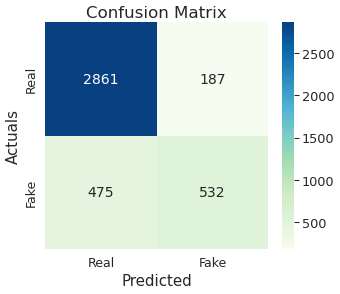

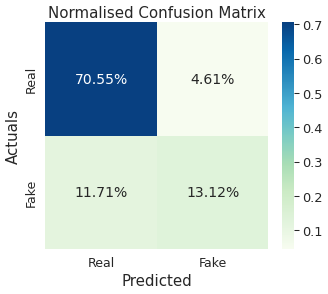

In [94]:
cm=confusion_matrix(y_test, pred)
path1="outputs//fakenewsnet_ml_glove//fakenewsnet_ml_RF_glove_cmtrx.png"
path2="outputs//fakenewsnet_ml_glove//fakenewsnet_ml_RF_glove_ncmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)

***

### Support Vector Machine

**Initialise the model and  fit it using train data and measure the accuracy metrics**

In [95]:
svm_clf=SVC(random_state=0,probability=True)

In [96]:
svm_clf.fit(glove_train_vectors,y_train)

pred = svm_clf.predict(glove_test_vectors)
print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Classification Report")
print(classification_report(y_test, pred))

Accuracy score : 0.8241676942046856
Confusion matrix : 
 [[2999   49]
 [ 664  343]]
Classification Report
              precision    recall  f1-score   support

           0       0.82      0.98      0.89      3048
           1       0.88      0.34      0.49      1007

    accuracy                           0.82      4055
   macro avg       0.85      0.66      0.69      4055
weighted avg       0.83      0.82      0.79      4055



### Hyperparameter Tuning 

Define the list of parameters which needed to do hyperparameter tuning

In [113]:
# Create the random grid
random_grid = {
    'C': [0.1, 1, 10, 100, 1000],
               'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
               'kernel':  ['rbf', 'poly', 'sigmoid'],
              }
pprint(random_grid)


{'C': [0.1, 1, 10, 100, 1000],
 'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
 'kernel': ['rbf', 'poly', 'sigmoid']}


**Initialise the model and fit using train data with hyperparameter tuning**

In [114]:

svm_clf1=SVC(random_state=0)

rf_random = RandomizedSearchCV(estimator=svm_clf1, param_distributions=random_grid,
                              n_iter = 50, 
                              cv = 5, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)


# Fit the random search model
rf_random.fit(glove_train_vectors,y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END ......................C=0.1, gamma=0.1, kernel=poly; total time=  45.8s
[CV] END .....................C=10, gamma=0.0001, kernel=rbf; total time= 2.1min
[CV] END ......................C=10, gamma=0.001, kernel=rbf; total time= 1.5min
[CV] END ..................C=100, gamma=0.01, kernel=sigmoid; total time= 1.1min
[CV] END .....................C=100, gamma=0.001, kernel=rbf; total time= 1.7min
[CV] END .....................C=1, gamma=0.0001, kernel=poly; total time=  59.8s
[CV] END ......................C=100, gamma=0.1, kernel=poly; total time= 1.8min
[CV] END ........................C=10, gamma=0.1, kernel=rbf; total time= 1.8min
[CV] END .....................C=100, gamma=1, kernel=sigmoid; total time=  58.4s
[CV] END ....................C=1000, gamma=1, kernel=sigmoid; total time=  55.5s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time= 1.7min
[CV] END ....................C=1000, gamma=0.00

[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time= 1.5min
[CV] END ...................C=0.1, gamma=0.1, kernel=sigmoid; total time= 1.2min
[CV] END ..........................C=1, gamma=1, kernel=poly; total time= 4.0min
[CV] END ...................C=0.1, gamma=0.0001, kernel=poly; total time= 1.3min
[CV] END .......................C=10, gamma=0.01, kernel=rbf; total time= 1.8min
[CV] END .......................C=1000, gamma=1, kernel=poly; total time=10.1min
[CV] END ...............C=1000, gamma=0.0001, kernel=sigmoid; total time= 1.5min
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time= 1.6min
[CV] END ......................C=1000, gamma=0.1, kernel=rbf; total time= 3.8min
[CV] END ..........................C=1, gamma=1, kernel=poly; total time= 4.0min
[CV] END ...............C=1000, gamma=0.0001, kernel=sigmoid; total time= 1.3min
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time= 1.8min
[CV] END ...................

RandomizedSearchCV(cv=5, estimator=SVC(random_state=0), n_iter=50, n_jobs=-1,
                   param_distributions={'C': [0.1, 1, 10, 100, 1000],
                                        'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                                        'kernel': ['rbf', 'poly', 'sigmoid']},
                   random_state=42, return_train_score=True, verbose=2)

In [116]:
rf_random.best_params_

{'kernel': 'rbf', 'gamma': 1, 'C': 10}

### Train SVM model  using Best Parameters after hyperparameter tuning

**Initialise the model and  fit it using train data and measure the accuracy metrics**

In [97]:
svm_clf_tuned_g=SVC(random_state=0,kernel='rbf',gamma=1,C=10,probability=True)

svm_clf_tuned_g.fit(glove_train_vectors, y_train.values.ravel())

# save the model to disk
filename = 'outputs//fakenewsnet_ml_glove//fakenewsnet_SVM_glove.sav'
pickle.dump(svm_clf_tuned_g, open(filename, 'wb'))
print('SVM - Completed')

SVM - Completed


In [98]:
#Loading the model
filename = 'outputs//fakenewsnet_ml_glove//fakenewsnet_SVM_glove.sav'

svm_clf_tuned_g = pickle.load(open(filename, 'rb'))

pred = svm_clf_tuned_g.predict(glove_test_vectors)
print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Classification Report")
print(classification_report(y_test, pred))
precision = precision_score(y_test, pred)
print("Precision : {}".format(precision))
recall = recall_score(y_test, pred)
print("Recall : {}".format(recall))
f1score = f1_score(y_test, pred)
print("F1 Score : {}".format(f1score))

Accuracy score : 0.8493218249075216
Confusion matrix : 
 [[2865  183]
 [ 428  579]]
Classification Report
              precision    recall  f1-score   support

           0       0.87      0.94      0.90      3048
           1       0.76      0.57      0.65      1007

    accuracy                           0.85      4055
   macro avg       0.81      0.76      0.78      4055
weighted avg       0.84      0.85      0.84      4055

Precision : 0.7598425196850394
Recall : 0.5749751737835154
F1 Score : 0.6546071226681741


**Save the classification report to csv**

In [99]:
report=classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("outputs//fakenewsnet_ml_glove//model_FAKENEWSNET_SVM_GLOVE_clasifctnrpt.csv")
df.head()

,precision,recall,f1-score,support
0,0.870027,0.939961,0.903643,3048.000000
1,0.759843,0.574975,0.654607,1007.000000
accuracy,0.849322,0.849322,0.849322,0.849322
macro avg,0.814935,0.757468,0.779125,4055.000000
weighted avg,0.842665,0.849322,0.841799,4055.000000


**Plot confusion matrix using the user defined functions as mentioned above earlier**

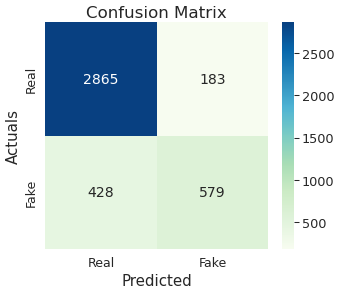

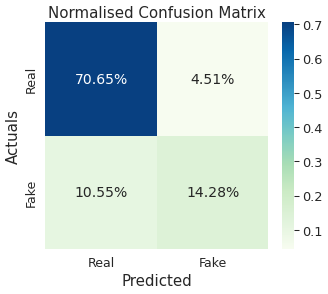

In [100]:
cm=confusion_matrix(y_test, pred)
path1="outputs//fakenewsnet_ml_glove//fakenewsnet_ml_SVM_glove_cmtrx.png"
path2="outputs//fakenewsnet_ml_glove//fakenewsnet_ml_SVM_glove_ncmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)

***

## KNN

**Initialise the model and  fit it using train data and measure the accuracy metrics**

In [101]:
#Create KNN Object.
knn_clf = KNeighborsClassifier()

In [102]:
knn_clf.fit(glove_train_vectors,y_train)

pred = knn_clf.predict(glove_test_vectors)
print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Classification Report")
print(classification_report(y_test, pred))

Accuracy score : 0.8022194821208385
Confusion matrix : 
 [[2763  285]
 [ 517  490]]
Classification Report
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      3048
           1       0.63      0.49      0.55      1007

    accuracy                           0.80      4055
   macro avg       0.74      0.70      0.71      4055
weighted avg       0.79      0.80      0.79      4055



### Hyperparameter Tuning 

Define the list of parameters which needed to do hyperparameter tuning

In [121]:
# Create the random grid
random_grid = {
    'leaf_size': list(range(1,50)),
               'n_neighbors': list(range(1,30)),
               'p':  [1,2],
              }
pprint(random_grid)

{'leaf_size': [1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
               47,
               48,
               49],
 'n_neighbors': [1,
                 2,
                 3,
                 

**Initialise the model and fit using train data with hyperparameter tuning**

In [122]:

knn_clf1=KNeighborsClassifier()

rf_random = RandomizedSearchCV(estimator=knn_clf1, param_distributions=random_grid,
                              n_iter = 100, 
                              cv = 3, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)


# Fit the random search model
rf_random.fit(glove_train_vectors,y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=KNeighborsClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'leaf_size': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19, 20, 21,
                                                      22, 23, 24, 25, 26, 27,
                                                      28, 29, 30, ...],
                                        'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8,
                                                        9, 10, 11, 12, 13, 14,
                                                        15, 16, 17, 18, 19, 20,
                                                        21, 22, 23, 24, 25, 26,
                                                        27, 28, 29],
                                        'p': [1, 2]},
                   random_state=42, return_train_score=True, verbose=2

In [123]:
rf_random.best_params_

{'p': 1, 'n_neighbors': 27, 'leaf_size': 13}

### Train KNN model  using Best Parameters after hyperparameter tuning

**Initialise the model and  fit it using train data and measure the accuracy metrics**

In [103]:
knn_clf_tuned_g=KNeighborsClassifier(n_neighbors=27,leaf_size=13,p=1)
knn_clf_tuned_g.fit(glove_train_vectors,y_train)

# save the model to disk
filename = 'outputs//fakenewsnet_ml_glove//fakenewsnet_KNN_glove.sav'
pickle.dump(knn_clf_tuned_g, open(filename, 'wb'))
print('KNN - Completed')

KNN - Completed


In [104]:
#Loading the model
filename = 'outputs//fakenewsnet_ml_glove//fakenewsnet_KNN_glove.sav'

knn_clf_tuned_g = pickle.load(open(filename, 'rb'))

pred = knn_clf_tuned_g.predict(glove_test_vectors)
print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Classification Report")
print(classification_report(y_test, pred))
precision = precision_score(y_test, pred)
print("Precision : {}".format(precision))
recall = recall_score(y_test, pred)
print("Recall : {}".format(recall))
f1score = f1_score(y_test, pred)
print("F1 Score : {}".format(f1score))

Accuracy score : 0.8246609124537608
Confusion matrix : 
 [[2927  121]
 [ 590  417]]
Classification Report
              precision    recall  f1-score   support

           0       0.83      0.96      0.89      3048
           1       0.78      0.41      0.54      1007

    accuracy                           0.82      4055
   macro avg       0.80      0.69      0.72      4055
weighted avg       0.82      0.82      0.80      4055

Precision : 0.775092936802974
Recall : 0.4141012909632572
F1 Score : 0.5398058252427184


**Save the classification report to csv**

In [105]:
report=classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("outputs//fakenewsnet_ml_glove//model_FAKENEWSNET_KNN_GLOVE_clasifctnrpt.csv")
df.head()

,precision,recall,f1-score,support
0,0.832243,0.960302,0.891698,3048.000000
1,0.775093,0.414101,0.539806,1007.000000
accuracy,0.824661,0.824661,0.824661,0.824661
macro avg,0.803668,0.687202,0.715752,4055.000000
weighted avg,0.818051,0.824661,0.804311,4055.000000


**Plot confusion matrix using the user defined functions as mentioned above earlier**

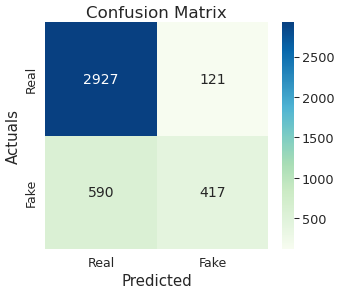

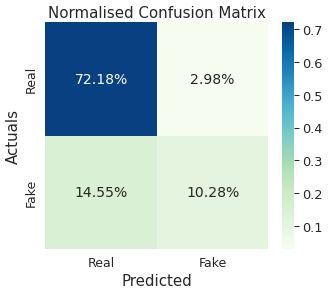

In [106]:
cm=confusion_matrix(y_test, pred)
path1="outputs//fakenewsnet_ml_glove//fakenewsnet_ml_KNN_glove_cmtrx.png"
path2="outputs//fakenewsnet_ml_glove//fakenewsnet_ml_KNN_glove_ncmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)

***

### Xgboost

**Initialise the model and  fit it using train data and measure the accuracy metrics**

In [107]:
#Create KNN Object.
xg_clf=XGBClassifier(random_state=0)

xg_clf.fit(glove_train_vectors,y_train)

pred = xg_clf.predict(glove_test_vectors)
print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Classification Report")
print(classification_report(y_test, pred))


Accuracy score : 0.8473489519112207
Confusion matrix : 
 [[2906  142]
 [ 477  530]]
Classification Report
              precision    recall  f1-score   support

           0       0.86      0.95      0.90      3048
           1       0.79      0.53      0.63      1007

    accuracy                           0.85      4055
   macro avg       0.82      0.74      0.77      4055
weighted avg       0.84      0.85      0.84      4055



### Hyperparameter Tuning 

Define the list of parameters which needed to do hyperparameter tuning

In [141]:
# Create the random grid
random_grid = {
    'min_child_weight': range(1,6,2),
    'gamma': list(range(1,30)),
    'max_depth':  range(3,15,2),
    'alpha': [1e-5, 1e-2, 0.1,1,10,50, 100],
    'subsample':np.arange(0.5, 1.0, 0.1),
    'scale_pos_weight':range(1,5,1),
    'colsample_bytree':np.arange(0.5, 1.0, 0.1),
    'n_estimators':[100, 250, 500],
    'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.4],
    'colsample_bylevel': np.arange(0.5, 1.0, 0.1),
    }
pprint(random_grid)

{'alpha': [1e-05, 0.01, 0.1, 1, 10, 50, 100],
 'colsample_bylevel': array([0.5, 0.6, 0.7, 0.8, 0.9]),
 'colsample_bytree': array([0.5, 0.6, 0.7, 0.8, 0.9]),
 'gamma': [1,
           2,
           3,
           4,
           5,
           6,
           7,
           8,
           9,
           10,
           11,
           12,
           13,
           14,
           15,
           16,
           17,
           18,
           19,
           20,
           21,
           22,
           23,
           24,
           25,
           26,
           27,
           28,
           29],
 'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.4],
 'max_depth': range(3, 15, 2),
 'min_child_weight': range(1, 6, 2),
 'n_estimators': [100, 250, 500],
 'scale_pos_weight': range(1, 5),
 'subsample': array([0.5, 0.6, 0.7, 0.8, 0.9])}


**Initialise the model and fit using train data with hyperparameter tuning**

In [142]:

xg_clf1=XGBClassifier(random_state=0)


rf_random = RandomizedSearchCV(estimator=xg_clf1, param_distributions=random_grid,
                              n_iter = 100, 
                              cv = 3, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)


# Fit the random search model
rf_random.fit(glove_train_vectors,y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,...
                                        'colsample_bytree': array([0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'gam

In [143]:
rf_random.best_params_

{'subsample': 0.7,
 'scale_pos_weight': 2,
 'n_estimators': 500,
 'min_child_weight': 1,
 'max_depth': 5,
 'learning_rate': 0.1,
 'gamma': 3,
 'colsample_bytree': 0.7999999999999999,
 'colsample_bylevel': 0.8999999999999999,
 'alpha': 1}

### Train XgBoost model  using Best Parameters after hyperparameter tuning

**Initialise the model and  fit it using train data and measure the accuracy metrics**

In [108]:
xg_clf_tuned_g=XGBClassifier(subsample=0.7,scale_pos_weight=2,n_estimators=500,min_child_weight=1,max_depth=5,learning_rate=0.1,
                     gamma=3,colsample_bytree=0.79,colsample_bylevel=0.89,alpha=1)
xg_clf_tuned_g.fit(glove_train_vectors,y_train)


# save the model to disk
filename = 'outputs//fakenewsnet_ml_glove//fakenewsnet_XG_glove.sav'
pickle.dump(xg_clf_tuned_g, open(filename, 'wb'))
print('XgBoost - Completed')

XgBoost - Completed


In [109]:
#Loading the model
filename = 'outputs//fakenewsnet_ml_glove//fakenewsnet_XG_glove.sav'

xg_clf_tuned_g = pickle.load(open(filename, 'rb'))

pred = xg_clf_tuned_g.predict(glove_test_vectors)
print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Classification Report")
print(classification_report(y_test, pred))
precision = precision_score(y_test, pred)
print("Precision : {}".format(precision))
recall = recall_score(y_test, pred)
print("Recall : {}".format(recall))
f1score = f1_score(y_test, pred)
print("F1 Score : {}".format(f1score))

Accuracy score : 0.8475955610357583
Confusion matrix : 
 [[2821  227]
 [ 391  616]]
Classification Report
              precision    recall  f1-score   support

           0       0.88      0.93      0.90      3048
           1       0.73      0.61      0.67      1007

    accuracy                           0.85      4055
   macro avg       0.80      0.77      0.78      4055
weighted avg       0.84      0.85      0.84      4055

Precision : 0.730723606168446
Recall : 0.6117179741807348
F1 Score : 0.6659459459459459


**Save the classification report to csv**

In [110]:
report=classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("outputs//fakenewsnet_ml_glove//model_FAKENEWSNET_XG_GLOVE_clasifctnrpt.csv")
df.head()

,precision,recall,f1-score,support
0,0.878269,0.925525,0.901278,3048.000000
1,0.730724,0.611718,0.665946,1007.000000
accuracy,0.847596,0.847596,0.847596,0.847596
macro avg,0.804496,0.768621,0.783612,4055.000000
weighted avg,0.841628,0.847596,0.842837,4055.000000


**Plot confusion matrix using the user defined functions as mentioned above earlier**

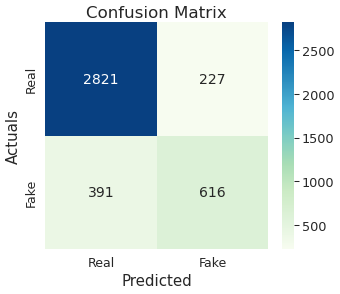

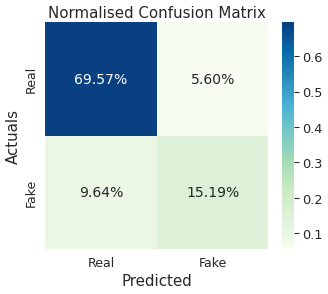

In [111]:
cm=confusion_matrix(y_test, pred)
path1="outputs//fakenewsnet_ml_glove//fakenewsnet_ml_XG_glove_cmtrx.png"
path2="outputs//fakenewsnet_ml_glove//fakenewsnet_ml_XG_glove_ncmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)

***

### Naiva Bayes

**Initialise the model and  fit it using train data and measure the accuracy metrics**

In [112]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import GaussianNB
nb_clf=GaussianNB()
#p = Pipeline([('Normalizing',MinMaxScaler()),('MultinomialNB',MultinomialNB())])
nb_clf.fit(glove_train_vectors,y_train) 

pred = nb_clf.predict(glove_test_vectors)
print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Classification Report")
print(classification_report(y_test, pred))

Accuracy score : 0.6180024660912454
Confusion matrix : 
 [[1740 1308]
 [ 241  766]]
Classification Report
              precision    recall  f1-score   support

           0       0.88      0.57      0.69      3048
           1       0.37      0.76      0.50      1007

    accuracy                           0.62      4055
   macro avg       0.62      0.67      0.59      4055
weighted avg       0.75      0.62      0.64      4055



### Hyperparameter Tuning 

Define the list of parameters which needed to do hyperparameter tuning

In [157]:
# Create the random grid
random_grid = {
    'var_smoothing': [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
#    # 'class_prior':[True,False],
#     'fit_prior':[True,False]
              }
pprint(random_grid)

{'var_smoothing': [1e-05, 0.0001, 0.001, 0.1, 1, 10, 100, 1000]}


**Initialise the model and fit using train data with hyperparameter tuning**

In [158]:

nb_clf1=GaussianNB()


rf_random = RandomizedSearchCV(estimator=nb_clf1, param_distributions=random_grid,
                              n_iter = 100, 
                              cv = 3, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)


# Fit the random search model
rf_random.fit(glove_train_vectors,y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


RandomizedSearchCV(cv=3, estimator=GaussianNB(), n_iter=100, n_jobs=-1,
                   param_distributions={'var_smoothing': [1e-05, 0.0001, 0.001,
                                                          0.1, 1, 10, 100,
                                                          1000]},
                   random_state=42, return_train_score=True, verbose=2)

In [159]:
rf_random.best_params_

{'var_smoothing': 10}

### Train Naive Bayes model  using Best Parameters after hyperparameter tuning

**Initialise the model and  fit it using train data and measure the accuracy metrics**

In [113]:
nb_clf_tuned_g=GaussianNB(var_smoothing=10)

nb_clf_tuned_g.fit(glove_train_vectors,y_train)

# save the model to disk
filename = 'outputs//fakenewsnet_ml_glove//fakenewsnet_NB_glove.sav'
pickle.dump(nb_clf_tuned_g, open(filename, 'wb'))
print('Naive Bayes - Completed')

Naive Bayes - Completed


In [123]:
#Loading the model
filename = 'outputs//fakenewsnet_ml_glove//fakenewsnet_NB_glove.sav'

nb_clf_tuned_g = pickle.load(open(filename, 'rb'))

#pred = nb_clf_tuned_g.predict(glove_test_vectors)

y_pred = nb_clf_tuned_g.predict_proba(glove_test_vectors)[:, 1]
pred=np.array((y_pred > 0.27).astype(int))

print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Classification Report")
print(classification_report(y_test, pred))
precision = precision_score(y_test, pred)
print("Precision : {}".format(precision))
recall = recall_score(y_test, pred)
print("Recall : {}".format(recall))
f1score = f1_score(y_test, pred)
print("F1 Score : {}".format(f1score))

Accuracy score : 0.6944512946979038
Confusion matrix : 
 [[2186  862]
 [ 377  630]]
Classification Report
              precision    recall  f1-score   support

           0       0.85      0.72      0.78      3048
           1       0.42      0.63      0.50      1007

    accuracy                           0.69      4055
   macro avg       0.64      0.67      0.64      4055
weighted avg       0.75      0.69      0.71      4055

Precision : 0.4222520107238606
Recall : 0.6256206554121152
F1 Score : 0.5042016806722689


**Save the classification report to csv**

In [124]:
report=classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("outputs//fakenewsnet_ml_glove//model_FAKENEWSNET_NB_GLOVE_clasifctnrpt.csv")
df.head()

,precision,recall,f1-score,support
0,0.852907,0.717192,0.779184,3048.000000
1,0.422252,0.625621,0.504202,1007.000000
accuracy,0.694451,0.694451,0.694451,0.694451
macro avg,0.637579,0.671406,0.641693,4055.000000
weighted avg,0.745960,0.694451,0.710896,4055.000000


**Plot confusion matrix using the user defined functions as mentioned above earlier**

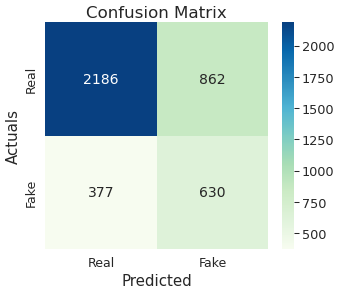

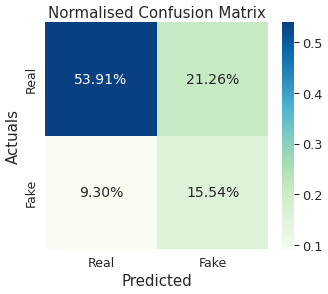

In [125]:
cm=confusion_matrix(y_test, pred)
path1="outputs//fakenewsnet_ml_glove//fakenewsnet_ml_NB_glove_cmtrx.png"
path2="outputs//fakenewsnet_ml_glove//fakenewsnet_ml_NB_glove_ncmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)

***

### Logistic Regression

**Initialise the model and  fit it using train data and measure the accuracy metrics**

In [126]:
from sklearn.linear_model import LogisticRegression

In [127]:
logticreg_clf=LogisticRegression()

logticreg_clf.fit(glove_train_vectors,y_train)

pred = logticreg_clf.predict(glove_test_vectors)
print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Classification Report")
print(classification_report(y_test, pred))

Accuracy score : 0.8231812577065352
Confusion matrix : 
 [[2923  125]
 [ 592  415]]
Classification Report
              precision    recall  f1-score   support

           0       0.83      0.96      0.89      3048
           1       0.77      0.41      0.54      1007

    accuracy                           0.82      4055
   macro avg       0.80      0.69      0.71      4055
weighted avg       0.82      0.82      0.80      4055



### Hyperparameter Tuning for Logistic Regression

Define the list of parameters which needed to do hyperparameter tuning

In [166]:
# Create the random grid
random_grid = {
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
     'C':[100, 10, 1.0, 0.1, 0.01],
    'penalty':['l1','l2','elasticnet']
              }
pprint(random_grid)

{'C': [100, 10, 1.0, 0.1, 0.01],
 'penalty': ['l1', 'l2', 'elasticnet'],
 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}


**Initialise the model and fit using train data with hyperparameter tuning**

In [167]:

logticreg_clf_tuned=LogisticRegression()


rf_random = RandomizedSearchCV(estimator=logticreg_clf_tuned, param_distributions=random_grid,
                              n_iter = 100, 
                              cv = 3, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)


# Fit the random search model
rf_random.fit(glove_train_vectors,y_train)

Fitting 3 folds for each of 75 candidates, totalling 225 fits


RandomizedSearchCV(cv=3, estimator=LogisticRegression(), n_iter=100, n_jobs=-1,
                   param_distributions={'C': [100, 10, 1.0, 0.1, 0.01],
                                        'penalty': ['l1', 'l2', 'elasticnet'],
                                        'solver': ['newton-cg', 'lbfgs',
                                                   'liblinear', 'sag',
                                                   'saga']},
                   random_state=42, return_train_score=True, verbose=2)

In [168]:
rf_random.best_params_

{'solver': 'liblinear', 'penalty': 'l1', 'C': 10}

### Train Logistic Regression model  using Best Parameters after hyperparameter tuning

**Initialise the model and  fit it using train data and measure the accuracy metrics**

In [131]:
logticreg_clf_tuned_g=LogisticRegression()

logticreg_clf_tuned_g.fit(glove_train_vectors,y_train)

# save the model to disk
filename = 'outputs//fakenewsnet_ml_glove//fakenewsnet_LR_glove.sav'
pickle.dump(logticreg_clf_tuned_g, open(filename, 'wb'))
print('Logisitic Regression - Completed')

Logisitic Regression - Completed


In [132]:
#Loading the model
filename = 'outputs//fakenewsnet_ml_glove//fakenewsnet_LR_glove.sav'

logticreg_clf_tuned_g = pickle.load(open(filename, 'rb'))

pred = logticreg_clf_tuned_g.predict(glove_test_vectors)

print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Classification Report")
print(classification_report(y_test, pred))
precision = precision_score(y_test, pred)
print("Precision : {}".format(precision))
recall = recall_score(y_test, pred)
print("Recall : {}".format(recall))
f1score = f1_score(y_test, pred)
print("F1 Score : {}".format(f1score))

Accuracy score : 0.8231812577065352
Confusion matrix : 
 [[2923  125]
 [ 592  415]]
Classification Report
              precision    recall  f1-score   support

           0       0.83      0.96      0.89      3048
           1       0.77      0.41      0.54      1007

    accuracy                           0.82      4055
   macro avg       0.80      0.69      0.71      4055
weighted avg       0.82      0.82      0.80      4055

Precision : 0.7685185185185185
Recall : 0.41211519364448856
F1 Score : 0.5365223012281836


**Save the classification report to csv**

In [133]:
report=classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("outputs//fakenewsnet_ml_glove//model_FAKENEWSNET_LR_GLOVE_clasifctnrpt.csv")
df.head()

,precision,recall,f1-score,support
0,0.831579,0.958990,0.890751,3048.000000
1,0.768519,0.412115,0.536522,1007.000000
accuracy,0.823181,0.823181,0.823181,0.823181
macro avg,0.800049,0.685552,0.713637,4055.000000
weighted avg,0.815919,0.823181,0.802784,4055.000000


**Plot confusion matrix using the user defined functions as mentioned above earlier**

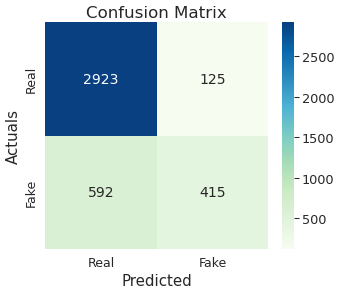

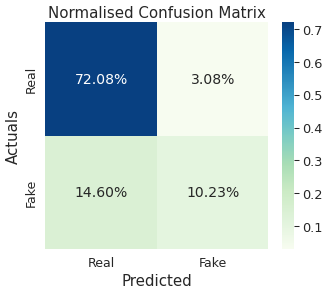

In [134]:
cm=confusion_matrix(y_test, pred)
path1="outputs//fakenewsnet_ml_glove//fakenewsnet_ml_LR_glove_cmtrx.png"
path2="outputs//fakenewsnet_ml_glove//fakenewsnet_ml_LR_glove_ncmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)

***

### ROC AUC Curve plot using all the algorithms

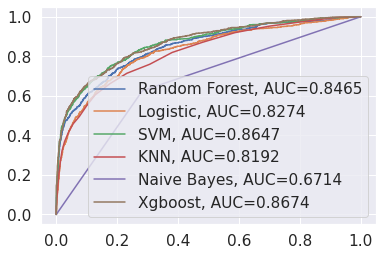

In [137]:
#set up plotting area
plt.figure(0).clf()

#fit RF model and plot ROC curve
y_pred = rf_clf_tuned_g.predict_proba(glove_test_vectors)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = round(roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Random Forest, AUC="+str(auc))

#fit Logistic model and plot ROC curve
y_pred = logticreg_clf_tuned_g.predict_proba(glove_test_vectors)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = round(roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Logistic, AUC="+str(auc))


#fit SVM model and plot ROC curve
y_pred = svm_clf_tuned_g.predict_proba(glove_test_vectors)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = round(roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="SVM, AUC="+str(auc))


#fit KNN model and plot ROC curve
y_pred = knn_clf_tuned_g.predict_proba(glove_test_vectors)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = round(roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="KNN, AUC="+str(auc))

#fit Naive Bayes model and plot ROC curve
y_pred = nb_clf_tuned_g.predict_proba(glove_test_vectors)[:, 1]
y_pred=np.array((y_pred > 0.27).astype(int))

fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = round(roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Naive Bayes, AUC="+str(auc))

#fit Xgboost model and plot ROC curve
y_pred = xg_clf_tuned_g.predict_proba(glove_test_vectors)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = round(roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Xgboost, AUC="+str(auc))

#add legend
plt.legend()
fig.savefig("outputs//fakenewsnet_ml_glove//ROC_AUC.png")